# A few MNIST experiements with TensorFlow

First, get the data:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot
from IPython import display

%matplotlib inline

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("./data/", one_hot=False)


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
def plotImages(images, imagesToShow = 10):
    #plot.rcParams["figure.figsize"] = 10, 10
    imgs = images[np.random.randint(images.shape[0], size=imagesToShow)]
    plot.imshow(np.hstack([(1.0 - i).reshape((28, 28)) for i in imgs]), cmap="gray")
    #display.display(plot.gcf())

Examples of images from training set:

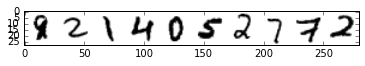

In [4]:
plotImages(mnist.train.images)

Define layer types:

In [13]:
image_size = 28
label_size = 10
# Input image dimensions (single channel)
input_dims = [image_size, image_size, 1]

# Features and labels
def inputs():
    features = tf.placeholder(tf.float32, shape=[None] + input_dims, name="features")
    labels = tf.placeholder(tf.float32, shape=[None], name="labels")
    return features, labels

# Cross-entropy loss with softmax activation function
def ce_sm_loss(logits, labels):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf.cast(labels, tf.int32), name="loss")

# Outputs (probabilities)
def probs_layer(logits):
    return tf.nn.softmax(logits)

# Fully-connected layer
def fc_layer(x, size, name):
    # Flatten dims for the fully-connected layer.
    x_flat = tf.reshape(x, [-1, x.get_shape()[1:].num_elements()])
    shape = [x_flat.get_shape()[1].value, size]
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name + "_W")
    b = tf.Variable(tf.constant(0.01, shape=[shape[1]]), name=name + "_b")
    return tf.matmul(x_flat, W) + b

# FC layer with ReLU
def fc_relu_layer(x, size, name=''):
    return tf.nn.relu(fc_layer(x, size, name))

def conv2d_relu_layer(x, kSize, mapCount=1, stride=1, name=''):
    # assuming x is already a 4D tensor
    shape = [kSize, kSize, x.get_shape()[3].value, mapCount]
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name + "_W")
    conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME', name=name + '_conv')
    return tf.nn.relu(conv)

def max_pool(x, kSize, stride=0, name=''):
    if stride <= 0:
        stride = kSize
    return tf.nn.max_pool(x, ksize=[1, kSize, kSize, 1], strides=[1, stride, stride, 1], 
                          padding='SAME', name=name + '_pool')


## Network topologies

### Simple, one-hidden layer net:

In [6]:
def simpleNet(features):
    h1_size = 200
    h1 = fc_relu_layer(features, h1_size, "h1")
    return h1

### Convolutional net:

In [7]:
def convNet_01(features):
    conv1 = conv2d_relu_layer(features, 5, 32, name='conv1')
    pool1 = max_pool(conv1, 2, name='pool1')
    conv2 = conv2d_relu_layer(pool1, 5, 32, name='conv2')
    pool2 = max_pool(conv2, 2, name='pool2')
    fc1 = fc_relu_layer(pool2, 128, 'fc1')
    return fc1

Build the graph:

In [86]:
def do_train(sess, train_step, loss, dataset, batch_size, epoch_size, num_epochs):
    for epoch in range(0, num_epochs):
        epoch_loss = 0.0
        for i in range(0, epoch_size, batch_size):
            cur_batch_size = min(batch_size, epoch_size - i)
            f, l = dataset.next_batch(cur_batch_size)
            _, loss_val = sess.run([train_step, loss],
                                   feed_dict={features: f.reshape([cur_batch_size] + input_dims), labels: l})
            epoch_loss += np.sum(loss_val)
        print "Epoch %d: loss = %0.05f" % (epoch, epoch_loss / epoch_size)
        
    
def do_eval(sess, logits, labels, dataset, batch_size):
    epoch_size = dataset.num_examples
    batch_correct = tf.reduce_sum(tf.cast(tf.nn.in_top_k(logits, tf.cast(labels, tf.int32), 1), tf.int32))
    correct = 0
    total = 0
    for i in range(0, epoch_size, batch_size):
        cur_batch_size = min(batch_size, epoch_size - i)
        f, l = dataset.next_batch(cur_batch_size)
        correct += np.sum(sess.run(batch_correct, feed_dict={
            features: f.reshape([cur_batch_size] + input_dims),
            labels: l}))
        total += cur_batch_size

    return total, correct

g = tf.Graph()
with g.as_default():
    features, labels = inputs()
    
    net1 = simpleNet(features)
    #net1 = convNet_01(features)
    
    logits = fc_layer(net1, label_size, "logits")
    probs = probs_layer(logits)
    loss = ce_sm_loss(logits, labels)
    
    tf.scalar_summary(loss.op.name, loss)
    
    train_step = tf.train.GradientDescentOptimizer(0.003).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        summary_writer = tf.train.SummaryWriter("/data/tf/log", sess.graph)
        summary_op = tf.merge_all_summaries()
        
        batch_size = 64
        epoch_size = mnist.train.num_examples
        num_epochs = 1
        do_train(sess, train_step, loss, mnist.train, batch_size, epoch_size, num_epochs)
        
        total, correct_count = do_eval(sess, probs, labels, mnist.test, 100)
        print('Test set accuracy: %0.04f (%d/%d)' % (correct_count / float(total), correct_count, total))
        
        #summary_str = sess.run(summary_op, feed_dict={
        #        features: mnist.test.images.reshape([mnist.test.num_examples] + input_dims),
        #        labels: mnist.test.labels})
        #summary_writer.add_summary(summary_str, 1)
        
        

Epoch 0: loss = 0.31633
Test set accuracy: 0.9514 (9514/10000)
